In [51]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['date'] = pd.to_datetime(data.date)
    print('Days: ',len(set(data.date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='amount', index=['date'],
                    columns=['start_id','end_id'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
dataDir = '/home/urwa/Documents/Projects/AnomalyDetection/Pipeline/data/'
dataFile = '20190402_TaipeiEdgesDatewise.csv'
events_data =dataDir+'TaipeiEvents.csv'

In [5]:
file = dataDir + dataFile
dataRaw = loadData(file)

Raw shape:  (7374816, 5)
Days:  638


In [6]:
dataIn =  pd.pivot_table(dataRaw, values='amount', index=['date'],
                    columns=['end_id'], aggfunc=np.sum, fill_value=0)
dataIn.head(1)

end_id,BL01,BL02,BL03,BL04,BL05,BL06,BL07,BL08,BL09,BL10,...,R20,R21,R22,R22A,R23,R24,R25,R26,R27,R28
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6326,11444,5696,16834,12256,25559,45609,27781,18745,33240,...,5597,5937,15733,12194,2972,2067,9518,8439,6473,73538


In [7]:
dataOut =  pd.pivot_table(dataRaw, values='amount', index=['date'],
                    columns=['start_id'], aggfunc=np.sum, fill_value=0)
dataOut.head(1)

start_id,BL01,BL02,BL03,BL04,BL05,BL06,BL07,BL08,BL09,BL10,...,R20,R21,R22,R22A,R23,R24,R25,R26,R27,R28
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6292,10268,5591,15834,12955,26456,42135,29606,18572,34387,...,5734,6801,14919,12373,2943,1957,8887,8603,6870,76751


In [8]:
matrix = np.stack((dataOut.values, dataIn.values),-1)
matrix.shape

(638, 108, 2)

In [69]:
for i in range(matrix.shape[1]):
    for j in range(matrix.shape[2]):
        matrix[:, i,j] = (matrix[:, i,j] - np.mean(matrix[:, i,j])) / (np.std(matrix[:, i,j]))

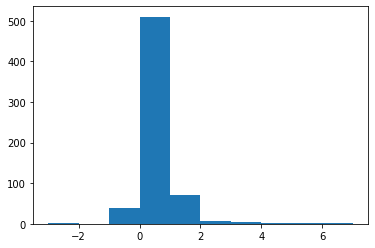

In [71]:
_ = plt.hist(matrix[:,10,1])

In [73]:
stations = list(set(dataRaw.start_id))
n= len(stations)
edge_index = [[a//n,a%n] for a in range(n*n)]
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [100]:
dates = list(set(dataOut.index))
DOW = list(pd.to_datetime(dataOut.index.values).dayofweek)
DOW = ((np.array(DOW) == 5) | (np.array(DOW) == 6)).astype(int)
DOW[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [101]:
dataList = []

for i in range(len(DOW)):
    x = torch.tensor(matrix[i], dtype=torch.float)
    y = torch.tensor(np.array([DOW[i]]), dtype=torch.long)
    data = Data(x=x, edge_index=edge_index.t().contiguous(),y=y)
    dataList.append(data)

dataList[0]

Data(edge_index=[2, 11664], x=[108, 2], y=[1])

In [102]:
n_classes = 2
featureDim = 2
hiddenDim = [16,4]

In [103]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(featureDim, hiddenDim[0])
        self.conv2 = GCNConv(hiddenDim[0], hiddenDim[1])
        self.linear1 = nn.Linear(n*hiddenDim[1], n_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.view(-1,n*hiddenDim[1])
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = Net().to(device)
#data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [105]:
device

device(type='cuda')

In [106]:
num_epochs = 50

In [107]:
model.train()

for epoch in range(num_epochs):
    epochLoss = 0
    for data in dataList:
        #data.view(1,-1,-1)
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
#         print(out.shape)
#         print(data.y.shape)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
        
    print('epoch [{}/{}], loss:{:.4f}'
    .format(epoch + 1, num_epochs, loss.item()))

epoch [1/50], loss:0.0564
epoch [2/50], loss:0.0554
epoch [3/50], loss:0.0726
epoch [4/50], loss:0.1043
epoch [5/50], loss:0.1216
epoch [6/50], loss:0.1029
epoch [7/50], loss:0.1127
epoch [8/50], loss:0.1552
epoch [9/50], loss:0.1290
epoch [10/50], loss:0.1053
epoch [11/50], loss:0.1004
epoch [12/50], loss:0.1266
epoch [13/50], loss:0.1239
epoch [14/50], loss:0.1690
epoch [15/50], loss:0.1471
epoch [16/50], loss:0.1335
epoch [17/50], loss:0.1158
epoch [18/50], loss:0.1049
epoch [19/50], loss:0.1176
epoch [20/50], loss:0.1228
epoch [21/50], loss:0.1163
epoch [22/50], loss:0.1090
epoch [23/50], loss:0.0985
epoch [24/50], loss:0.0522
epoch [25/50], loss:0.0568
epoch [26/50], loss:0.1474
epoch [27/50], loss:0.0792
epoch [28/50], loss:0.1085
epoch [29/50], loss:0.1305
epoch [30/50], loss:0.0967
epoch [31/50], loss:0.1455
epoch [32/50], loss:0.0567
epoch [33/50], loss:0.0555
epoch [34/50], loss:0.1292
epoch [35/50], loss:0.1020
epoch [36/50], loss:0.0864
epoch [37/50], loss:0.0955
epoch [38/

In [108]:
model.eval()
with torch.no_grad():
    y = DOW
    predList = []
    for data in dataList:
        data = data.to(device)
        pred = model(data).cpu().numpy()
        predList.append(np.argmax(pred))
    
    print('Accuracy: {:.4f}'.format( np.sum(np.array(predList) == np.array(y)) / len(predList) ))

Accuracy: 0.8715


In [135]:
dates = list(set(dataOut.index))
DOW = list(pd.to_datetime(dataOut.index.values).dayofweek)
#DOW = ((np.array(DOW) == 5) | (np.array(DOW) == 6)).astype(int)
DOW[:10]

[6, 0, 1, 2, 3, 4, 5, 6, 0, 1]

In [136]:
n_classes = 7
featureDim = matrix.shape[1] * matrix.shape[2]
hiddenDim = [500,100]

In [137]:
class LinNet(torch.nn.Module):
    def __init__(self):
        super(LinNet, self).__init__()
        self.linear1 = nn.Linear(featureDim, hiddenDim[0])
        self.linear2 = nn.Linear(hiddenDim[0], hiddenDim[1])
        self.linear3 = nn.Linear(hiddenDim[1], n_classes)

    def forward(self, x):
        #x, edge_index = data.x, data.edge_index
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        #x = x.view(-1,n*hiddenDim[1])
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = LinNet().to(device)
#data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [139]:
num_epochs = 20

In [140]:
Y = torch.tensor(np.array(DOW), dtype=torch.long)

In [141]:
model.train()

for epoch in range(num_epochs):
    epochLoss = 0
    for i in range(matrix.shape[0]):
        data = torch.tensor(matrix[i,:,:], dtype=torch.float).view(1,-1)
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
#         print(out.shape)
#         print(data.y.shape)
        y = Y[i].to(device).view(1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
        
    print('epoch [{}/{}], loss:{:.4f}'
    .format(epoch + 1, num_epochs, loss.item()))

epoch [1/20], loss:319.2292
epoch [2/20], loss:0.0000
epoch [3/20], loss:146.9484
epoch [4/20], loss:35.2669
epoch [5/20], loss:199.2574
epoch [6/20], loss:0.0000
epoch [7/20], loss:339.3034
epoch [8/20], loss:0.0004
epoch [9/20], loss:0.0000
epoch [10/20], loss:0.0000
epoch [11/20], loss:0.0000
epoch [12/20], loss:904.2885
epoch [13/20], loss:0.0000
epoch [14/20], loss:0.0000
epoch [15/20], loss:0.0000
epoch [16/20], loss:0.0000
epoch [17/20], loss:0.0000
epoch [18/20], loss:0.0000
epoch [19/20], loss:0.0000
epoch [20/20], loss:0.0000


In [142]:
model.eval()
with torch.no_grad():
    y = DOW
    predList = []
    for i in range(matrix.shape[0]):
        data = torch.tensor(matrix[i,:,:], dtype=torch.float).view(1,-1)
        data = data.to(device)
        pred = model(data).cpu().numpy()
        predList.append(np.argmax(pred))
    
    print('Accuracy: {:.4f}'.format( np.sum(np.array(predList) == np.array(y)) / len(predList) ))

Accuracy: 0.6708


In [143]:
DOW[:20]

[6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4]

In [144]:
predList[:20]

[6, 0, 2, 2, 2, 4, 5, 0, 2, 3, 2, 2, 4, 5, 6, 0, 1, 1, 3, 4]